<a href="https://colab.research.google.com/github/maya609/DS2002-midterm-project/blob/main/DS2002_ETL_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS2002 Data Project 1: ETL Pipeline
This notebook implements an ETL pipeline for a city dataset.

In [ ]:
import requests
import pandas as pd
import time
import sqlite3
import json

API_KEY = "f760e730e6c8cae778375ffa133ce403"

# Function to fetch weather data for a given latitude & longitude
def fetch_weather(lat, lon):
    url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()  # return full JSON response
    else:
        return {"error": f"status_code {response.status_code}"}

# Load the mounted CSV dataset
df = pd.read_csv("/content/sample_data/worldcitiespop.csv", low_memory=False)
#df = df.head(10)
df = df.drop(columns=["AccentCity", "Region"], errors="ignore")

# Save summary of original CSV
original_summary = {
    "records": df.shape[0],
    "columns": df.shape[1]
}

# Check for Latitude and Longitude
if "Latitude" in df.columns and "Longitude" in df.columns:
    summarized_data = []
    raw_weather_json = []

    for index, row in df.iterrows():
        lat, lon = row["Latitude"], row["Longitude"]
        weather_json = fetch_weather(lat, lon)
        raw_weather_json.append(weather_json)

        # Extract summary fields for merging
        if "main" in weather_json and "weather" in weather_json and "wind" in weather_json:
            summarized_data.append({
                "Temperature": weather_json["main"]["temp"],
                "Weather_Condition": weather_json["weather"][0]["description"],
                "Humidity": weather_json["main"]["humidity"],
                "Wind_Speed": weather_json["wind"]["speed"]
            })
        else:
            summarized_data.append({
                "Temperature": None,
                "Weather_Condition": None,
                "Humidity": None,
                "Wind_Speed": None
            })

        time.sleep(1)

    # Merge summarized weather data with main CSV dataset
    weather_df = pd.DataFrame(summarized_data)
    df = pd.concat([df, weather_df], axis=1)

    # Save summary of transformed main dataset
    transformed_summary = {
        "records": df.shape[0],
        "columns": df.shape[1]
    }

    # Save CSV-based data to SQLite (required)
    conn = sqlite3.connect("output.db")
    df.to_sql("weather_table", conn, if_exists="replace", index=False)
    conn.close()
    print("Main dataset saved to SQLite database as 'weather_table'.")

    # Export raw JSON responses as a second dataset
    with open("raw_weather_responses.json", "w") as f:
        json.dump(raw_weather_json, f, indent=4)
    print("Full weather API responses saved to 'raw_weather_responses.json'.")

    # Normalize and export JSON as CSV + SQL (optional)
    json_df = pd.json_normalize(raw_weather_json)
    json_df.to_csv("weather_json_data.csv", index=False)
    for col in json_df.columns:
        json_df[col] = json_df[col].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)

    # Save summary of normalized JSON dataset
    json_summary = {
        "records": json_df.shape[0],
        "columns": json_df.shape[1]
    }

    conn = sqlite3.connect("output.db")
    json_df.to_sql("weather_json", conn, if_exists="replace", index=False)
    conn.close()
    print("Normalized weather JSON saved as 'weather_json_data.csv' and to SQL table 'weather_json'.")

    # Optional export format (for user output)
    output_format = input("Choose format to save main dataset (csv/json/sql): ").strip().lower()
    if output_format == "csv":
        df.to_csv("output.csv", index=False)
        print("Exported main dataset to CSV: output.csv")
    elif output_format == "json":
        df.to_json("output.json", orient="records", indent=4)
        print("Exported main dataset to JSON: output.json")
    elif output_format == "sql":
        print("SQL export already completed above.")
    else:
        print("Invalid option.")

    # Print all summaries
    print("\nData Summarization:")
    print("\nOriginal CSV Dataset:")
    print(f"Number of Records: {original_summary['records']}")
    print(f"Number of Columns: {original_summary['columns']}")

    print("\nTransformed JSON Dataset (weather API):")
    print(f"Number of Records: {json_summary['records']}")
    print(f"Number of Columns: {json_summary['columns']}")

    print("\nFinal Merged Dataset:")
    print(f"Number of Records: {transformed_summary['records']}")
    print(f"Number of Columns: {transformed_summary['columns']}")
else:
    print("Error: Latitude and Longitude columns not found.")


Main dataset saved to SQLite database as 'weather_table'.
Full weather API responses saved to 'raw_weather_responses.json'.
Normalized weather JSON saved as 'weather_json_data.csv' and to SQL table 'weather_json'.
Choose format to save main dataset (csv/json/sql): csv
Exported main dataset to CSV: output.csv

Data Summarization:

Original CSV Dataset:
Number of Records: 100
Number of Columns: 5

Transformed JSON Dataset (weather API):
Number of Records: 100
Number of Columns: 29

Final Merged Dataset:
Number of Records: 100
Number of Columns: 9


Correlation between Population and Temperature: -0.34


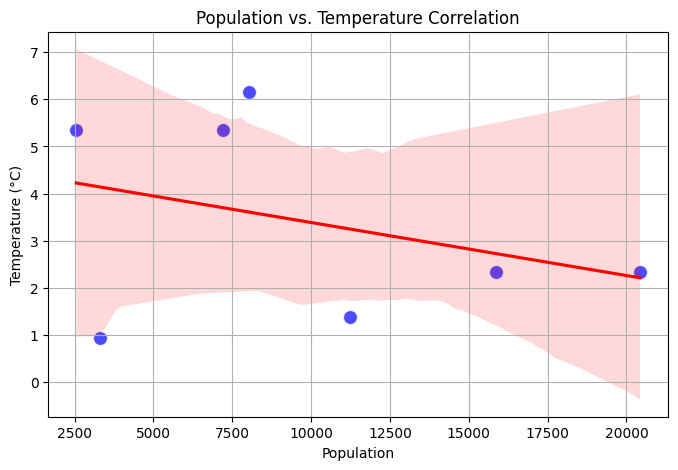

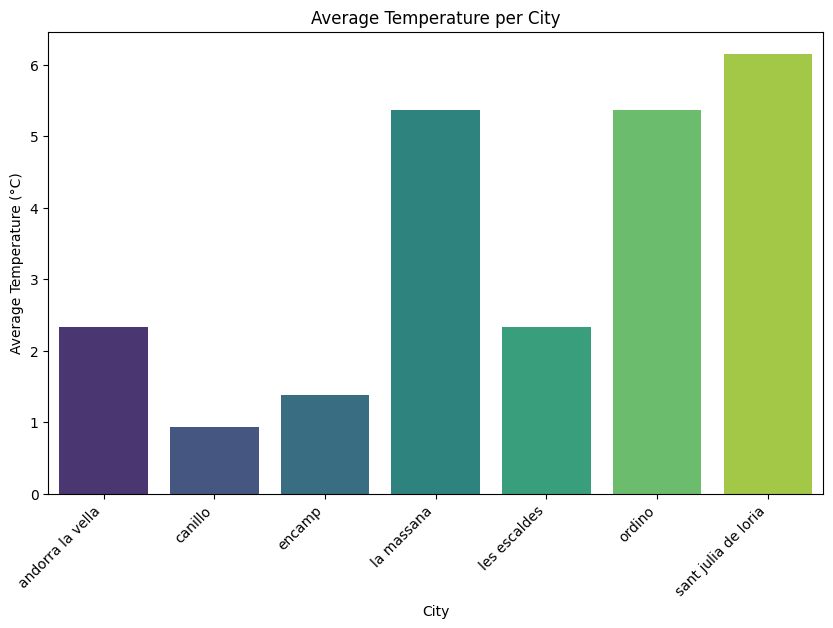

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_cleaned = df.dropna(subset=["Population"]).loc[df['City'] != 'abu dhabi']

# Displays correlation coefficient between pop. and temp.
correlation = df_cleaned["Population"].corr(df_cleaned["Temperature"])
print(f"Correlation between Population and Temperature: {correlation:.2f}")

# Scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_cleaned, x="Population", y="Temperature", color="blue", s=100, alpha=0.7)

# Trendline
sns.regplot(data=df_cleaned, x="Population", y="Temperature", scatter=False, color="red")

# Bar chart
plt.title("Population vs. Temperature Correlation")
plt.xlabel("Population")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x="City", y="Temperature", hue="City", palette="viridis")

plt.title("Average Temperature per City")
plt.xlabel("City")
plt.ylabel("Average Temperature (°C)")
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()